In [9]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import ones,vstack
from numpy.linalg import lstsq
from matplotlib import _cntr as cntr
import tensorflow as tf

from data import sample_gmm_2d, graph_data,graph_surface, labels_to_one_hot
from confusion_matrix import get_confusion_matrix
from confusion_matrix import eval_AP
from confusion_matrix import eval_perf_multi

In [2]:
def fcann2_train(X,Y_, std = 1.0):
    input_size = 2
    hidden_size = 2
    output_size = 2
    learning_rate = 0.5
    n_iter = 10000
    
    W1 = std * np.random.randn(input_size, hidden_size)
    b1 = np.zeros(hidden_size)
    W2 = std * np.random.randn(hidden_size, output_size)
    b2 = np.zeros(output_size)
    
    for i in range(n_iter):
        layer_1, layer_2, probs = fcann2_forward(X,W1,b1,W2,b2)
        if i % 2000 == 0:
            val = -np.log(probs)
            loss = np.sum(val)/len(Y_)
            print "Loss = %f" %(loss)
        #grad softmax
        dscores = probs
        dscores[range(len(Y_)),Y_] -= 1
        dscores /= len(Y_)
        
        #grad last layer
        grad_W2 = np.dot(layer_1.T,dscores)
        grad_b2 = np.sum(dscores,axis=0)
        
        #grad trough relu
        grad_trough_relu = np.dot(dscores,W2.T)
        grad_trough_relu[layer_1<=0] = 0
        
        #grad first layer
        grad_W1 = np.dot(X.T,grad_trough_relu)
        grad_b1 = np.sum(grad_trough_relu,axis=0)
        
        
        W2+= -learning_rate*grad_W2
        b2+= -learning_rate*grad_b2
        W1+= -learning_rate*grad_W1
        b1+= -learning_rate*grad_b1
        
    return W2, b2, W1, b1
        
    
def fcann2_forward(X,W1,b1,W2,b2):
    # Compute the forward pass
    scores = None
    l1 = X.dot(W1) + b1
    l1 = np.dot(X, W1) + b1
    l1[l1<=0] = 0 # ReLu
    scores = l1.dot(W2) + b2
    scores_exp= np.exp(scores)
    sum_exp=np.sum(np.exp(scores),axis=1)
    probabilities = scores_exp/ sum_exp[:,None]
    return l1, scores, probabilities

def predict_c1_class(X,W1,b1,W2,b2):
    def classify(X):
        return fcann2_forward(X,W1,b1,W2,b2)[2][:,1]
    return classify


4700
Loss = 1.420328
Loss = 3.894219
Loss = 3.917971
Loss = 3.894612
Loss = 3.895129


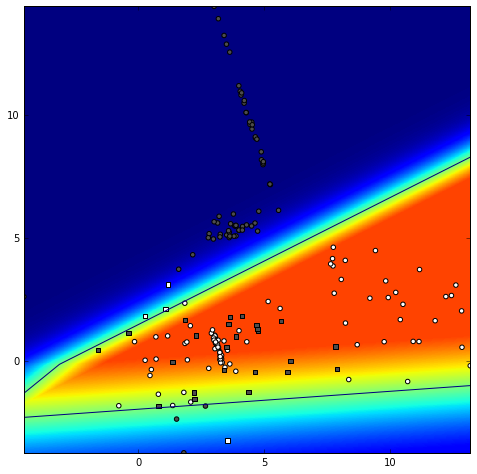

In [3]:
#np.random.seed(25321) isus... sve ista klasa za 4 2 30
# seed = 119 0.5 i 10000
#seed = 2519 eo nezz
# seed = 2215 0.01 learning rate 10000 iteracija
# 4700
seed = np.random.randint(0,5000)
print seed
np.random.seed(seed)
input_data, expected_output = sample_gmm_2d(6,2,30)

W2, b2, W1, b1 = fcann2_train(input_data, expected_output)
decfun = predict_c1_class(input_data,W1,b1,W2,b2)

# evaluate the model on the train set
probs = decfun(input_data)

# recover the predicted classes Y
my_predictions = probs >0.5
my_predictions = my_predictions.flatten()


# graph the decision surface
bbox=(np.min(input_data, axis=0), np.max(input_data, axis=0))

#axis limits of the graph
xmin, ymin = bbox[0]
xmax, ymax = bbox[1]
plt.figure(figsize=(8,8))
plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])

graph_surface(decfun, bbox, offset=0.5)

# graph the data points
graph_data(input_data, expected_output, my_predictions)

# show the plot
plt.show()


[array([  2.76442099,   4.8699832 ,   6.97554493,   9.08110714,  11.18666935], dtype=float32)]
[array([  2.76442099,   4.8699832 ,   6.97554493,   9.08110714,  11.18666935], dtype=float32)]


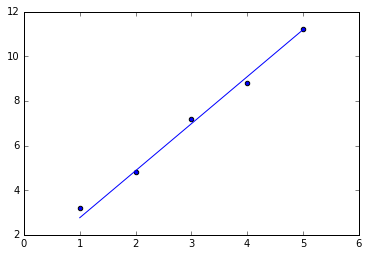

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

input_data = [1,2,3,4,5]
output_data = [3.2,4.8,7.2,8.8,11.2]
## 1. definicija računskog grafa
# podatci i parametri
X  = tf.placeholder(tf.float32, [None])
Y_ = tf.placeholder(tf.float32, [None])
a = tf.Variable(0.0)
b = tf.Variable(0.0)

polovina = tf.constant(0.5,tf.float32)

# afini regresijski model
Y = a * X + b

# kvadratni gubitak  * 0.5 da se derivacijom rijesi ova polovina i bude better
loss = polovina* (Y-Y_)**2 * (1./len(input_data))

# optimizacijski postupak: gradijentni spust learning rate ubije sveee aaaaa
trainer = tf.train.GradientDescentOptimizer(0.01)
train_op = trainer.minimize(loss)

## 2. inicijalizacija parametara
sess = tf.Session()
sess.run(tf.initialize_all_variables())
y_valid = Y
#gradient definišn
grads_and_vars = trainer.compute_gradients(loss, var_list=[a,b],)
apply_grads = trainer.apply_gradients(grads_and_vars)
## 3. učenje
# neka igre počnu!
for i in range(100):
    
    #value = sess.run([grads_and_vars], feed_dict={X: [1], Y_: [3]})
    #print value
    #print "vrijednost izlaza", sess.run([Y], feed_dict={X: [1]})
    
    #moj analiticki gradijent :D
    #print (sess.run([Y], feed_dict={X: [1]})[0] - 3)* 1
    
    sess.run(apply_grads,feed_dict={X: input_data, Y_: output_data})
    #print i
#     test tf.Printa
#     test = tf.constant([1.0,2.0])
#     test2 = tf.Print(test,[test],message=("test varijablica "))
#     sess.run([test2]) #printa u terminal :'( suzice
    
#     print i
#     print
#     val_loss, _, val_a,val_b = sess.run([loss, train_op, a,b], 
#         feed_dict={X: [1,2,3,4], Y_: [3,5,7,9]})
    #print(i,val_loss, val_a,val_b)
print
print sess.run([Y], feed_dict={X:input_data})
print sess.run([y_valid], feed_dict={X:input_data})
plt.scatter(input_data,output_data)
plt.plot(input_data,sess.run([Y], feed_dict={X:input_data})[0])
plt.show()
sess.close()

In [65]:
class TFLogreg:
    def __init__(self,D, C, param_delta=0.01,param_lambda=1e-4):
        """Arguments:
           - D: dimensions of each datapoint
           - param_delta: training step
        """
        
        self.sess = tf.Session()
        
        # definicija podataka i parametara:
        # definirati self.X, self.Yoh_, self.W, self.b
        # ...
        self.X = tf.placeholder(tf.float32, [None,D])
        self.Yoh_ = tf.placeholder(tf.float32, [None,C])
        self.W = tf.Variable(tf.random_normal([D,C]))
        self.b1 = tf.Variable(tf.random_normal([C]))

        # formulacija modela: izračunati self.probs
        #   koristiti: tf.matmul, tf.nn.softmax
        # ...
        self.model_score = tf.matmul(self.X,self.W) + self.b1
        self.model_softmax = tf.nn.softmax(self.model_score) #vektor C
        self.Y = self.model_softmax

        # formulacija gubitka: self.loss
        #   koristiti: tf.log, tf.reduce_sum, tf.reduce_mean
        # ...
        #Y - izlaz
        #Yoh - onehot 
        self.loss = (tf.reduce_mean(-tf.reduce_sum(tf.log(self.Y)*self.Yoh_,reduction_indices=1)
                    + param_lambda*tf.nn.l2_loss(self.W)))

        # formulacija operacije učenja: self.train_step
        #   koristiti: tf.train.GradientDescentOptimizer,
        #              tf.train.GradientDescentOptimizer.minimize
        # ...
        self.trainer = tf.train.GradientDescentOptimizer(param_delta)
        self.optimizer = self.trainer.minimize(self.loss)
        # instanciranje izvedbenog konteksta: self.session
        #   koristiti: tf.Session
        # ...
        
        pass

    def train(self, X, Yoh_, param_niter):
        """Arguments:
           - X: actual datapoints [NxD]
           - Yoh_: one-hot encoded labels [NxC]
           - param_niter: number of iterations
        """
        # incijalizacija parametara
        #   koristiti: tf.initialize_all_variables
        # ...
        self.sess.run(tf.initialize_all_variables())
        for i in range(param_niter):
            _, loss = self.sess.run([self.optimizer, self.loss], feed_dict={self.X: X, self.Yoh_: Yoh_})
        # optimizacijska petlja
        #   koristiti: tf.Session.run
        # ...
        pass
        
    def eval(self, X):
        """Arguments:
           - X: actual datapoints [NxD]
           Returns: predicted class probabilites [NxC]
        """
        #   koristiti: tf.Session.run
        return self.sess.run(self.Y,feed_dict={self.X:X})
        pass
    
    def __del__(self):
        self.sess.close()

In [2]:
class TFDeep:
    def __init__(self, layer, param_delta=0.01, param_lambda=1e-4):
        """Arguments:
           - D: dimensions of each datapoint 
           - C: number of classes
           - param_delta: training step
        """
        
        self.sess = tf.Session()
        
        # definicija podataka i parametara:
        # definirati self.X, self.Yoh_, self.W, self.b
        # ...
        self.X = tf.placeholder(tf.float32, [None,layer[0]])
        self.Yoh_ = tf.placeholder(tf.float32, [None,layer[-1]])
        prev = layer[0]
        out = self.X
        
        #Makni kad prebacis u pycharm
        l2_reg= None
        for dim in layer[1:-1]:
            temp_W = tf.Variable(tf.random_normal([prev,dim]))
            temp_b = tf.Variable(tf.random_normal([dim]))
            out = tf.nn.relu(tf.matmul(out,temp_W)+temp_b)
            prev = dim
            if l2_reg == None:
                l2_reg = tf.nn.l2_loss(temp_W) + tf.nn.l2_loss(temp_b)
            else:
                l2_reg += tf.nn.l2_loss(temp_W) + tf.nn.l2_loss(temp_b)
            
            
        temp_W = tf.Variable(tf.random_normal([prev,layer[-1]]))
        temp_b = tf.Variable(tf.random_normal([layer[-1]]))
        out = tf.nn.softmax(tf.matmul(out,temp_W)+temp_b)
        l2_reg += tf.nn.l2_loss(temp_W) + tf.nn.l2_loss(temp_b)
        
        self.Y = out

        # formulacija gubitka: self.loss
        #   koristiti: tf.log, tf.reduce_sum, tf.reduce_mean
        # ...
        #Y - izlaz
        #Yoh - onehot 
        self.loss = (tf.reduce_mean(-tf.reduce_sum(tf.log(self.Y)*self.Yoh_,reduction_indices=1)
                        + param_lambda*l2_reg))

        # formulacija operacije učenja: self.train_step
        #   koristiti: tf.train.GradientDescentOptimizer,
        #              tf.train.GradientDescentOptimizer.minimize
        # ...
        self.trainer = tf.train.GradientDescentOptimizer(param_delta)
        self.optimizer = self.trainer.minimize(self.loss)
        # instanciranje izvedbenog konteksta: self.session
        #   koristiti: tf.Session
        # ...
        
        pass

    def train(self, X, Yoh_, param_niter):
        """Arguments:
           - X: actual datapoints [NxD]
           - Yoh_: one-hot encoded labels [NxC]
           - param_niter: number of iterations
        """
        # incijalizacija parametara
        #   koristiti: tf.initialize_all_variables
        # ...
        self.sess.run(tf.initialize_all_variables())
        for i in range(param_niter):
            _, loss = self.sess.run([self.optimizer, self.loss], feed_dict={self.X: X, self.Yoh_: Yoh_})
        # optimizacijska petlja
        #   koristiti: tf.Session.run
        # ...
        pass
        
    def eval(self, X):
        """Arguments:
           - X: actual datapoints [NxD]
           Returns: predicted class probabilites [NxC]
        """
        #   koristiti: tf.Session.run
        return self.sess.run(self.Y,feed_dict={self.X:X})
        pass
    
    def __del__(self):
        self.sess.close()

In [17]:
from sklearn import svm
class KSVMWrap:
    def __init__(self, X, Y_, c=1, g='auto'):
        """Arguments:
            X,Y_: podatci i točni indeksi razreda
            c:    relativni značaj podatkovne cijene
            g:    širina RBF jezgre
        """
        self.clf = svm.SVC(C=c,gamma=g,probability=True)
        self.clf.fit(X, Y_)

    def predict(self, X):
        return self.clf.fit(X, Y_)
        
    def scores(self, X):
        #np.where(clf.classes_ == zeljena klasa)
        return self.clf.classes_, self.clf.predict_proba(X) 
    
    def support(self):
        return self.clf.support_

      0  1
  0[ 57  3]
  1[  1119]
precision
[0.98275862068965514, 0.97540983606557374]
recall
[0.94999999999999996, 0.9916666666666667]
AP_c0
0.995968448068
AP_c1
0.998880493509


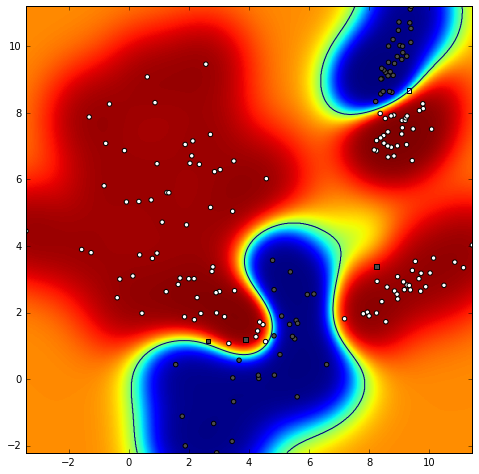

In [19]:
def predict_c1_class_tf(X):
    def classify(X):
        return tfLog.eval(X)[:,1]
    return classify

def predict_c1_class_tf(X):
    def classify(X):
        return tfLog.scores(X)[1][:,1]
    return classify

C=2
#seed = np.random.randint(0,500000)
#print seed
np.random.seed(423245)
#306285
#423245
layers = [2,5,5,3,2,2]
input_data, expected_output = sample_gmm_2d(6,C,30)

# tfLog = TFLogreg(2,C)
#tfLog = TFDeep(layers)
#tfLog.train(input_data,labels_to_one_hot(expected_output,C),10000)
tfLog = KSVMWrap(input_data,expected_output)
decfun = predict_c1_class_tf(input_data)

# evaluate the model on the train set
#probs = tfLog.eval(input_data)
probs = tfLog.scores(input_data)[1]

# recover the predicted classes Y
my_predictions = probs[:,1] >0.5
my_predictions = my_predictions.flatten()


# graph the decision surface
bbox=(np.min(input_data, axis=0), np.max(input_data, axis=0))

#axis limits of the graph
xmin, ymin = bbox[0]
xmax, ymax = bbox[1]
plt.figure(figsize=(8,8))
plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])

possible_labels = np.array(range(C))
mat = get_confusion_matrix(my_predictions,expected_output,possible_labels,True)
prec, rec = eval_perf_multi(mat)
AP_c0 = eval_AP(expected_output[probs[:,0].argsort()],0)
AP_c1 = eval_AP(expected_output[probs[:,1].argsort()],1)

print "precision"
print prec
print "recall"
print rec
print "AP_c0"
print AP_c0
print "AP_c1"
print AP_c1

graph_surface(decfun, bbox, offset=0.5)

# graph the data points
graph_data(input_data, expected_output, my_predictions)

# show the plot
plt.show()

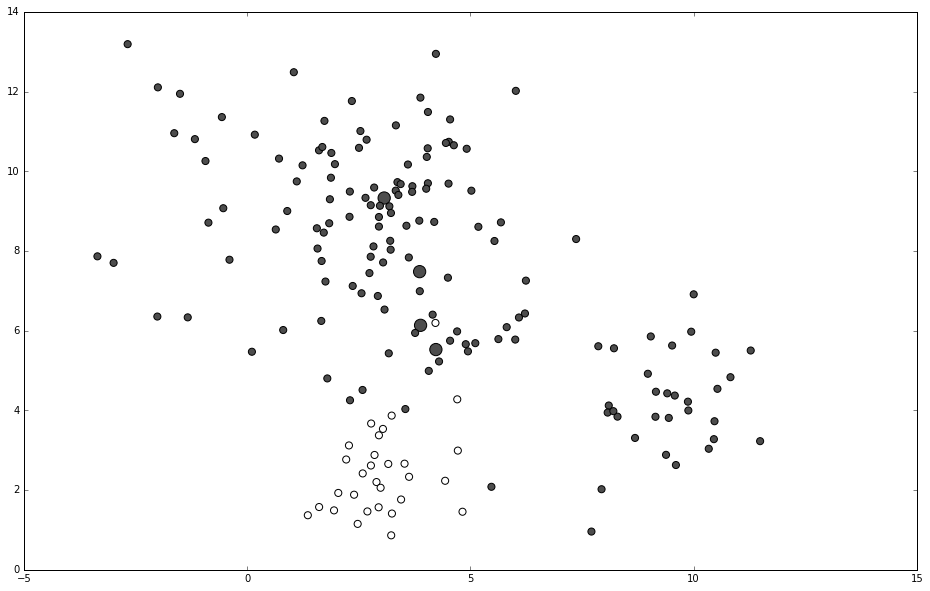

In [123]:
def graph_data(X, Y_, Y, special=None):
    correct = np.where(Y == Y_)
    incorrect = np.where(Y != Y_)
    correctly_classified = X[correct]
    incorrectly_classified = X[incorrect]
    
    sizes = np.array([50]*len(X))
    if special != None:
        sizes[special] *=3
    
    correct_sizes = sizes[correct]
    incorrect_sizes = sizes[incorrect]
    
    colors = np.array([0.3] * len(X))
    colors[np.where(Y_ == 1)] = 1

    color_correct = colors[np.where(Y == Y_)]
    color_incorrect = colors[np.where(Y != Y_)]

    plt.scatter(correctly_classified[:, 0], correctly_classified[:, 1],
                color=zip(color_correct, color_correct, color_correct), marker='o', edgecolors=(0, 0, 0),s = correct_sizes)
    plt.scatter(incorrectly_classified[:, 0], incorrectly_classified[:, 1],
                color=zip(color_incorrect, color_incorrect, color_incorrect), marker='s', edgecolors=(0, 0, 0),s = incorrect_sizes)

plt.figure(figsize=(16,10))
input_data, expected_output = sample_gmm_2d(6,C,30)
# graph the data points
graph_data(input_data, expected_output, expected_output, special = [1,5,10,15])
plt.show()